<a id='index'></a>
##### Index
* <a href='#introduction'>Introduction</a>
* <a href='#data'>Processed data</a>
    * <a href='#data:load'>Data loading</a>
    * <a href='#data:visualization'>Data visualization</a>


* <a href='#model'>Model definition and hyperparameter optimization</a>
    * <a href='#model:cat_oc'>One Class classification models</a>
        * <a href='#model_oc:ocsvm'>One Class SVM</a>
        * <a href='#model_oc:AU'>One Class AutoEncoder</a>
        * <a href='#model_oc:...'>...</a>
        
    * <a href='#model:cat_binary'>Binary (supervised) classification models</a>
        * <a href='#model_binary:svm'>SVM</a>
        * <a href='#model_binary:AU'>Autoencoder</a>
        * <a href='#model_binary:...'>...</a>

        
* <a href='#results'>Results</a>
* <a href='#conclusions'>Conclusions</a>


    


<a href='#index'>...</a>
<a id='introduction'></a>
# Introduction

**Imports**

In [1]:
import pandas as pd
import sklearn
import numpy as np
from scipy import stats

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold

# Plot
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from prettytable import PrettyTable
sns.set()

# Configuration
from tqdm.notebook import tqdm
import warnings
from ipywidgets import IntProgress
from IPython import display
import time
import os
import json

# Models
from sklearn.svm import OneClassSVM
from pyod.models import ocsvm
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split

# Evaluation
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer, roc_curve, auc, plot_roc_curve
from sklearn.metrics import confusion_matrix


**Environment configuration**

In [2]:
def set_display_range(range_columns=pd.options.display.max_columns, range_rows=pd.options.display.max_rows, reset_columns=0, reset_rows=0):
    pd.set_option('display.max_columns', range_columns)
    pd.set_option('display.max_rows', range_rows)
    if (reset_columns): pd.reset_option('display.max_columns')
    if (reset_rows): pd.reset_option('display.max_rows')

set_display_range(range_columns=None, range_rows=10)

<a href='#index'>...</a>
<a id='data'></a>
# Processed data

<a id='data:load'></a>
## Data loading

![multistarts](media/multistart.png "multistarts")

In [207]:
root_folder_proc = '../OneClass/OneClass_'

# oc_42
df_oc42_X_train = pd.read_csv(root_folder_proc+'42/X_train_42.csv', sep=';')
df_oc42_X_test = pd.read_csv(root_folder_proc+'42/X_test_42.csv', sep=';')
df_oc42_Y_train = pd.read_csv(root_folder_proc+'42/y_train.csv', sep=';')
df_oc42_Y_test = pd.read_csv(root_folder_proc+'42/y_test.csv', sep=';')

# oc_89
df_oc89_X_train = pd.read_csv(root_folder_proc+'89/X_train_89.csv', sep=';')
df_oc89_X_test = pd.read_csv(root_folder_proc+'89/X_test_89.csv', sep=';')
df_oc89_Y_train = pd.read_csv(root_folder_proc+'89/y_train.csv', sep=';')
df_oc89_Y_test = pd.read_csv(root_folder_proc+'89/y_test.csv', sep=';')

# oc_101
df_oc101_X_train = pd.read_csv(root_folder_proc+'101/X_train_101.csv', sep=';')
df_oc101_X_test = pd.read_csv(root_folder_proc+'101/X_test_101.csv', sep=';')
df_oc101_Y_train = pd.read_csv(root_folder_proc+'101/y_train.csv', sep=';')
df_oc101_Y_test = pd.read_csv(root_folder_proc+'101/y_test.csv', sep=';')

# oc_151
df_oc151_X_train = pd.read_csv(root_folder_proc+'151/X_train_151.csv', sep=';')
df_oc151_X_test = pd.read_csv(root_folder_proc+'151/X_test_151.csv', sep=';')
df_oc151_Y_train = pd.read_csv(root_folder_proc+'151/y_train.csv', sep=';')
df_oc151_Y_test = pd.read_csv(root_folder_proc+'151/y_test.csv', sep=';')

# oc_223
df_oc223_X_train = pd.read_csv(root_folder_proc+'223/X_train_223.csv', sep=';')
df_oc223_X_test = pd.read_csv(root_folder_proc+'223/X_test_223.csv', sep=';')
df_oc223_Y_train = pd.read_csv(root_folder_proc+'223/y_train.csv', sep=';')
df_oc223_Y_test = pd.read_csv(root_folder_proc+'223/y_test.csv', sep=';')

In [208]:
target_df = [(df_oc42_Y_train, df_oc42_Y_test), (df_oc89_Y_train, df_oc89_Y_test), (df_oc101_Y_train, df_oc101_Y_test), (df_oc151_Y_train, df_oc151_Y_test), (df_oc223_Y_train, df_oc223_Y_test)]
content_df = [(df_oc42_X_train, df_oc42_X_test), (df_oc89_X_train, df_oc89_X_test), (df_oc101_X_train, df_oc101_X_test), (df_oc151_X_train, df_oc151_X_test), (df_oc223_X_train, df_oc223_X_test)]
ms = [42, 89, 101, 151, 189]

CORE_collection = {}
# CORE_collection structure: dictionary of (float) list
# # CORE_collection[@random_state] = list
# Example: 
# CORE_collection = {42: [1,2,3,4...], 89: [6,9,23,34,...], etc}

X_collection = {}
# X_collection structure: dictionary of (float)-list touple
# X_collection[@random_state] = (X_train_df, Y_train_df)

Y_collection = {}              
# Y_collection structure: dictionary of (float)-list touple
# Y_collection[@random_state] = (Y_train_df, Y_train_df)

for Y, X, RS in zip(target_df, content_df, ms):
    Y[0].loc[Y[0]['ED0DISWHY']==0.0]=-1
    Y[1].loc[Y[1]['ED0DISWHY']==0.0]=-1
    Y[0]['ED0DISWHY'] = Y[0]['ED0DISWHY'].astype("int64")
    Y[1]['ED0DISWHY'] = Y[1]['ED0DISWHY'].astype("int64")
              
    CORE_collection[RS] = (X[0]['CORE'],X[1]['CORE'])
    X_collection[RS] = (X[0].drop(columns=['CORE']), X[1].drop(columns=['CORE']))
    Y_collection[RS] = (Y[0], Y[1])

    
X_data = pd.concat([X_collection[42][0], X_collection[42][1]],axis=0)
Y_data = pd.concat([Y_collection[42][0], Y_collection[42][1]],axis=0)


<a id='data:visualization'></a>
## Data visualization

**Function definition**

In [6]:
def column_percentage(df, column, main_label):
    try:
        return len(df.loc[df[column]==main_label])/len(df)
    except:
        return -1

In [7]:
def plot_zero_relevance(df, columns, dim_x, dim_y, main_title='SAMPLE TITLE', titles=None, verbose=0):
    '''
    Prints histogram for every columns desired in a dataframe.
    
    Parameters.
    ------------
    df: Pandas Dataframe
        Data dataframe
        
    columns:  String[]
              Array containning the names of the desired columns
              
    dim_x: int
           Size of the x axis of plot grid. 
    
    dim_y: int
           Size of the y axis of plot grid.
           
    main_title: String
                Title of the figure.
                
    titles: String[]
            Array containing the subtitle of every plot.
    
    verbose: int
             1 to activate verbose mode. Otherwise, hide prints.
                
    '''
    col = 0
    total = df.shape[0]
    if (verbose) : print("Number of 0's:")
    if (titles == None) : titles=columns 
    fig, axes = plt.subplots(dim_x, dim_y, figsize=(16,8))
    fig.suptitle(main_title)
    try:
        for i in range(dim_x):
            for j in range(dim_y):
                if (verbose):
                    print("* "+titles[col]+" \t{} ({:.2f}%)".format(sum(df[columns[col]]==0),sum(df[columns[col]]==0)/total*100))
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    ax = sns.distplot(ax=axes[i,j], x=df[columns[col]], color='#388E3C') # hist=True
                if (ax.lines != []):
                    kde_x, kde_y = ax.lines[0].get_data()
                    ax.fill_between(kde_x, kde_y, where=(kde_x<max(df[columns[col]])*0.1), interpolate=True, color='#EF9A9A')
                axes[i,j].set_title(titles[col])  
                col+=1
    except:
        pass

In [8]:
def zero_relevance(df, columns):
    '''
    Prints 0 value percentage in defined columns.
    
    Parameters.
    ------------
    df: Pandas Dataframe
        Data dataframe
        
    columns:  String[]
              Array containning the names of the desired columns to print  
    '''
    print("Percentage of 0's per column:")
    total = df.shape[0]
    for col in columns:
        print("* "+col+" \t{} ({:.2f}%)".format(sum(df[col]==0),sum(df[col]==0)/total*100))
               

In [9]:
def plot_pair_individual(X, Y, x1, x2):
    '''
    Plots a pair-plot type grid axes for 2 features and one target.
    
    Parameters.
    ------------
    X:  Pandas Dataframe
        X data store.
    
    Y:  Pandas Dataframe
        Y (target) data store.
        
    x1:  String
        Name of the first column
        
    x1:  String
        Name of the second column
    '''
    fig, ax = plt.subplots()
    index = Y.index
    normal_index = index[Y['ED0DISWHY']==1]
    anomaly_index = index[Y['ED0DISWHY']==-1]
    X_normal = X.iloc[normal_index]
    X_anomaly = X.iloc[anomaly_index]
    ax.scatter(X_anomaly[x1], X_anomaly[x2], c='plum', alpha=0.7, label='Anomaly samples')
    ax.scatter(X_normal[x1], X_normal[x2], c='rebeccapurple', alpha=0.7, label='Positive samples')
    plt.xlabel(x1)
    plt.ylabel(x2)
    leg = ax.legend()

In [10]:
def plot_box_plot(X, Y, features, save=0):
    '''
    Plots plot-box type grid axes for 1 feature and one target.
    
    Parameters.
    ------------
    X:  Pandas Dataframe
        X data store.
    
    Y:  Pandas Dataframe
        Y (target) data store.
        
    features: String[]
              Array containning the names of the desired columns to print
  
    save: int
            1 value, save plots. Otherwise, print plots.
    '''
    path = './boxplots'
    if (not os.path.isdir(path)):
        try:
            os.mkdir(path)
        except OSError:
            print ("Creation of the directory %s failed" % path)
        else:
            print ("Successfully created the directory %s " % path)
    for feat in features:
        boxp = sns.boxplot(y=X[feat],x=Y['ED0DISWHY'])
        if (save):
            fig = boxp.get_figure()
            fig.savefig(path+'/bp_'+feat+'.png')
            plt.close()
        else:
            plt.show()

# plot_box_plot(X=X_collection[42][0], Y=Y_collection[42][0], features=X_collection[42][0].columns, save=1

**0 value percetange per column.**

Printing the percentage of samples with value 0 per all columns. Excluiding those features which have 0 as a suitable value.

In [11]:
zero_relevance_columns = ['CT0000ADW', 'CT00000AP', 'CT000APTT', 'CT00000BT', 'CT000CHCM', 'CT00000DD', 'CT0000GGT', 'CT0000GLU', 'CT0000GOT', 'CT0000GPT', 'CT0000HCM', 'CT000HCTO', 'CT0000HEM', 'CT0000HGB', 'CT0000INR', 'CT000000K', 'CT0000LDH', 'CT000LEUC', 'CT0000LIN', 'CT000LINP', 'CT00MONOP', 'CT00000NA', 'CT0000NEU', 'CT000NEUP', 'CT0000PCR', 'CT000PLAQ', 'CT00000TP', 'CT000000U', 'CT0000VCM', 'CT0000VPM', 'CTHSDXXRATE','CTHSDXXSAT']
zero_relevance(X_data, zero_relevance_columns)

Percentage of 0's per column:
* CT0000ADW 	0 (0.00%)
* CT00000AP 	0 (0.00%)
* CT000APTT 	0 (0.00%)
* CT00000BT 	0 (0.00%)
* CT000CHCM 	0 (0.00%)
* CT00000DD 	0 (0.00%)
* CT0000GGT 	0 (0.00%)
* CT0000GLU 	0 (0.00%)
* CT0000GOT 	0 (0.00%)
* CT0000GPT 	0 (0.00%)
* CT0000HCM 	0 (0.00%)
* CT000HCTO 	0 (0.00%)
* CT0000HEM 	0 (0.00%)
* CT0000HGB 	0 (0.00%)
* CT0000INR 	0 (0.00%)
* CT000000K 	0 (0.00%)
* CT0000LDH 	0 (0.00%)
* CT000LEUC 	0 (0.00%)
* CT0000LIN 	0 (0.00%)
* CT000LINP 	0 (0.00%)
* CT00MONOP 	0 (0.00%)
* CT00000NA 	0 (0.00%)
* CT0000NEU 	0 (0.00%)
* CT000NEUP 	0 (0.00%)
* CT0000PCR 	0 (0.00%)
* CT000PLAQ 	0 (0.00%)
* CT00000TP 	0 (0.00%)
* CT000000U 	0 (0.00%)
* CT0000VCM 	0 (0.00%)
* CT0000VPM 	0 (0.00%)
* CTHSDXXRATE 	0 (0.00%)
* CTHSDXXSAT 	0 (0.00%)


**Pairwise representation of features, visualizing the relationship with the target class.**

Individual pairs.

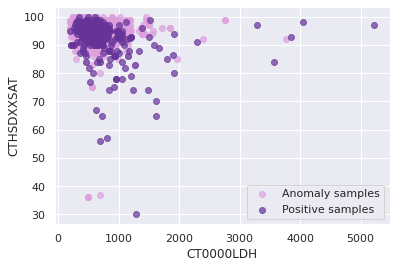

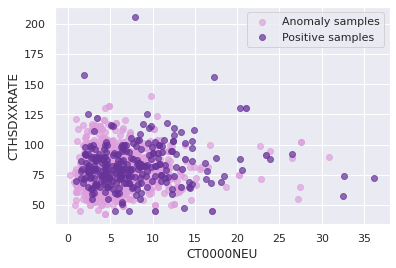

In [12]:
plot_pair_individual(X_data, Y_data, 'CT0000LDH', 'CTHSDXXSAT')
plot_pair_individual(X_data, Y_data, 'CT0000NEU', 'CTHSDXXRATE')

Record features taken during admission and registered information about diagnosis and procedements (according to CIE10 codification).

Text(0.5, 1.08, "Positive/anomaly samples' features taken during admision and diagnosis/procedements values (according to CIE10 codification)")

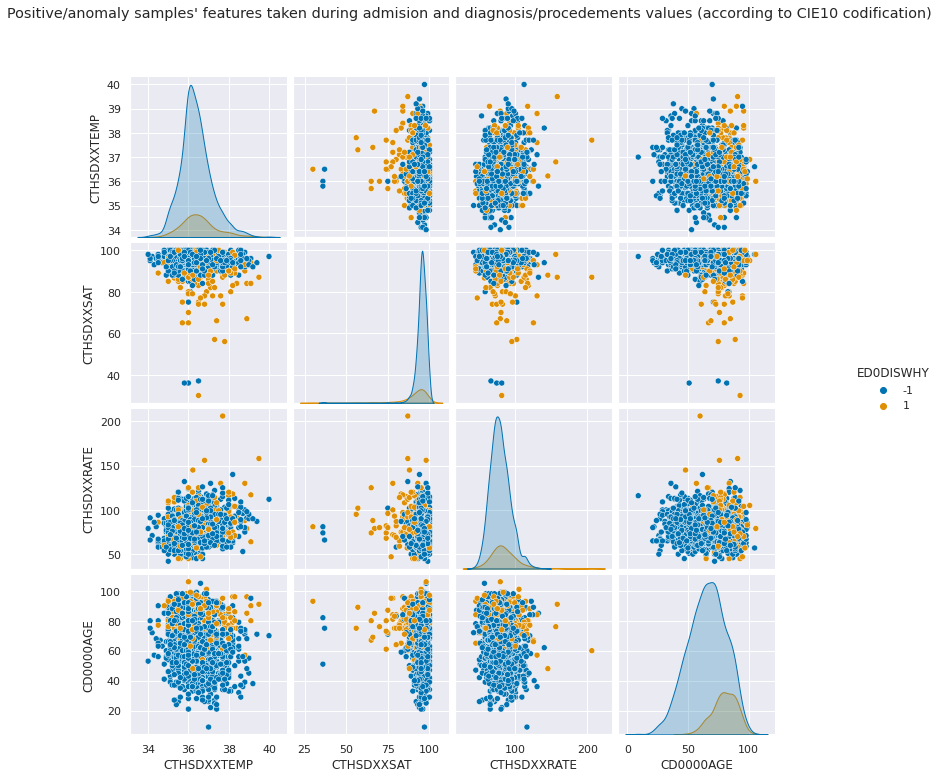

In [13]:
pp = sns.pairplot(pd.concat([X_data[['CTHSDXXTEMP', 'CTHSDXXSAT', 'CTHSDXXRATE', 'CD0000AGE']], Y_data],axis=1), hue='ED0DISWHY', palette='colorblind')
pp.fig.suptitle("Positive/anomaly samples' features taken during admision and diagnosis/procedements values (according to CIE10 codification)", y=1.08)

Distribution representation of features for positive and anomaly samples.


<a id='data:feature'></a>
## Feature selection

**Histogram of features**


In [196]:
universe = 42

# CT0000DD > 10000
index = X_collection[universe][0].loc[X_collection[universe][0]['CT00000DD']>10000].index.tolist()
# CT0000GOT > 200
index += X_collection[universe][0].loc[X_collection[universe][0]['CT0000GOT']>200].index.tolist()
# CT0000GPT > 200
index += X_collection[universe][0].loc[X_collection[universe][0]['CT0000GPT']>200].index.tolist()

index = np.unique(index)
X_collection[universe][0].drop(labels=index, inplace=True)
Y_collection[universe][0].drop(labels=index, inplace=True)
print(f'Removed a total of {len(index)} rows.')

Removed a total of 71 rows.


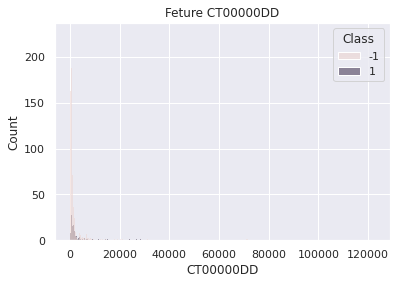

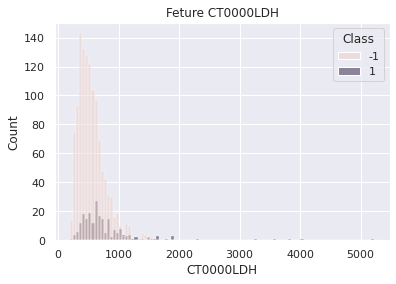

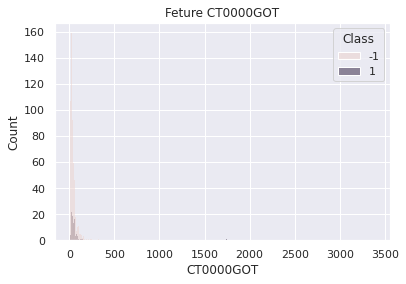

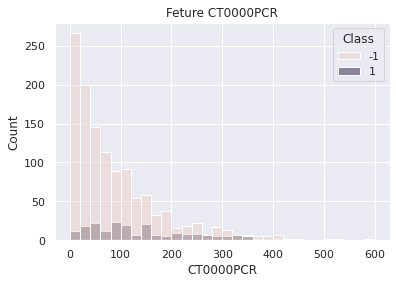

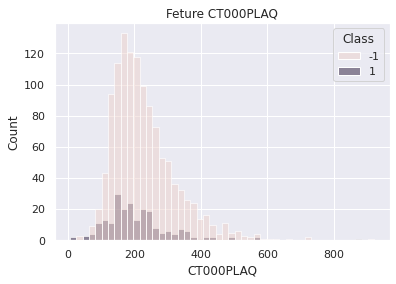

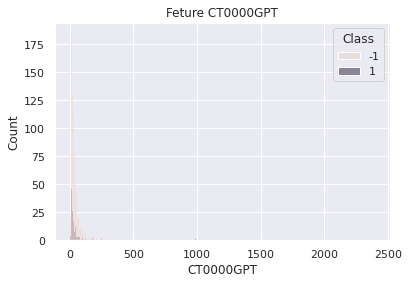

In [111]:
universe = 42

data = X_collection[universe][0]
data['Class'] = Y_collection[universe][0]['ED0DISWHY']

feat = 'CT00000DD'
sns.histplot(data=data, x=feat, hue="Class")
plt.title(f'Feture {feat}')
plt.show()

feat = 'CT0000LDH'
sns.histplot(data=data, x=feat, hue="Class")
plt.title(f'Feture {feat}')
plt.show()

feat = 'CT0000GOT'
sns.histplot(data=data, x=feat, hue="Class")
plt.title(f'Feture {feat}')
plt.show()

feat = 'CT0000PCR'
sns.histplot(data=data, x=feat, hue="Class")
plt.title(f'Feture {feat}')
plt.show()

feat = 'CT000PLAQ'
sns.histplot(data=data, x=feat, hue="Class")
plt.title(f'Feture {feat}')
plt.show()

feat = 'CT0000GPT'
sns.histplot(data=data, x=feat, hue="Class")
plt.title(f'Feture {feat}')
plt.show()

**Selecting features based on variance**

In [14]:
## Feature selection / filtering based on variance per feature

threshold = 0.06
columns = X_collection[42][0].columns
print('Selected variance threshold: ',threshold)
for universe in ms:
    remove = []
    for col in columns:
        var = X_collection[universe][0][col].var()
        if (var<threshold): remove.append(col)
    print('Removed columns [',universe,']: ',remove)
    X_collection[universe][0].drop(columns=remove, axis=1, inplace=True)
    X_collection[universe][1].drop(columns=remove, axis=1, inplace=True)
    

Selected variance threshold:  0.06
Removed columns [ 42 ]:  ['CT0000BAS', 'CT0000EOS']
Removed columns [ 89 ]:  ['CT0000BAS', 'CT0000EOS']
Removed columns [ 101 ]:  ['CT0000BAS', 'CT0000EOS']
Removed columns [ 151 ]:  ['CT0000BAS', 'CT0000EOS']
Removed columns [ 189 ]:  ['CT0000BAS', 'CT0000EOS']


In [116]:
## Feature selection / filtering based on leaderboard of features based on variance (from most [top1] to least [top last] variance)

columns = X_collection[42][0].columns.to_numpy()

## Keep columns that are not desired to remove
keep = ['CD000MSEX', 'CD000FSEX']
columns = np.setdiff1d(columns, keep)

variance = {k: None for k in columns}
for universe in ms:
    remove = []
    print(f'Universe {universe} top variance:')
    for col in columns:
        var = X_collection[universe][0][col].var()
        variance[col] = var
    
    variance = {k: v for k, v in sorted(variance.items(), key=lambda item: item[1], reverse=True)}
    for i, col in zip(range(len(variance)), variance): 
        print(f"{i+1}. {col}: {variance[col]:.3f}")
    
    # X_collection[universe][0].drop(columns=remove, axis=1, inplace=True)
    # X_collection[universe][1].drop(columns=remove, axis=1, inplace=True)

Universe 42 top variance:
1. CT00000DD: 1942997.693
2. CT0000LDH: 83766.119
3. CT0000PCR: 10022.686
4. CT000PLAQ: 9616.354
5. CT0000GGT: 7509.079
6. CT0000GLU: 2031.297
7. CT000000U: 976.588
8. CT0000GPT: 865.937
9. CT0000GOT: 738.456
10. CT00000AP: 272.611
11. CD0000AGE: 245.499
12. CT00000TP: 226.486
13. CTHSDXXRATE: 214.020
14. CT000NEUP: 176.015
15. CT000LINP: 114.479
16. CT000APTT: 51.066
17. CT0000VCM: 32.983
18. CT000HCTO: 26.884
19. CTHSDXXSAT: 25.576
20. CT000LEUC: 21.512
21. CT00000NA: 19.301
22. CT00MONOP: 18.482
23. CT0000NEU: 13.419
24. CT0000HCM: 5.392
25. CT0000ADW: 3.846
26. CT000MONO: 3.759
27. CT0000HGB: 3.620
28. CT000EOSP: 2.797
29. CT0000LIN: 2.457
30. CT000CHCM: 2.136
31. CT0000INR: 2.100
32. CT0000VPM: 0.948
33. CTHSDXXTEMP: 0.613
34. CT0000COM: 0.597
35. CT0000HEM: 0.425
36. CT000000K: 0.293
37. CT000CREA: 0.255
38. CT00000BT: 0.164
39. CT000BASP: 0.090
40. CT0000SYM: 0.067
41. CT0000EOS: 0.058
42. CT0000BAS: 0.000
Universe 89 top variance:
1. CT00000DD: 4539073

In [119]:
## Feature selection / filtering based on leaderboard of features based on MAD (from most [top1] to least [top last] variance)

columns = X_collection[42][0].columns.to_numpy()

## Keep columns that are not desired to remove
keep = ['CD000MSEX', 'CD000FSEX']
columns = np.setdiff1d(columns, keep)

variance = {k: None for k in columns}
for universe in ms:
    remove = []
    print(f'Universe {universe} top variance:')
    for col in columns:
        var = stats.median_absolute_deviation(X_collection[universe][0][col])
        variance[col] = var
    
    variance = {k: v for k, v in sorted(variance.items(), key=lambda item: item[1], reverse=True)}
    for i, col in zip(range(len(variance)), variance): 
        print(f"{i+1}. {col}: {variance[col]:.3f}")
    
    # X_collection[universe][0].drop(columns=remove, axis=1, inplace=True)
    # X_collection[universe][1].drop(columns=remove, axis=1, inplace=True)

Universe 42 top variance:
1. CT00000DD: 502.601
2. CT0000LDH: 193.628
3. CT000PLAQ: 78.578
4. CT0000PCR: 70.438
5. CT0000GGT: 36.620
6. CT0000GLU: 22.536
7. CD0000AGE: 17.791
8. CT0000GPT: 17.198
9. CT0000GOT: 16.902
10. CT000000U: 15.360
11. CT00000AP: 13.343
12. CT000NEUP: 13.343
13. CTHSDXXRATE: 13.343
14. CT000LINP: 10.823
15. CT0000VCM: 4.596
16. CT000HCTO: 4.596
17. CT00MONOP: 3.706
18. CT000APTT: 3.558
19. CT00000NA: 3.262
20. CTHSDXXSAT: 2.965
21. CT000LEUC: 2.698
22. CT0000NEU: 2.387
23. CT0000HCM: 1.779
24. CT0000HGB: 1.779
25. CT00000TP: 1.483
26. CT0000ADW: 1.483
27. CT000CHCM: 1.186
28. CT0000VPM: 1.038
29. CTHSDXXTEMP: 0.593
30. CT0000HEM: 0.578
31. CT0000LIN: 0.519
32. CT000000K: 0.474
33. CT000EOSP: 0.297
34. CT000CREA: 0.282
35. CT000MONO: 0.237
36. CT00000BT: 0.208
37. CT000BASP: 0.148
38. CT0000INR: 0.133
39. CT0000BAS: 0.015
40. CT0000EOS: 0.015
41. CT0000COM: 0.000
42. CT0000SYM: 0.000
Universe 89 top variance:
1. CT00000DD: 512.238
2. CT0000LDH: 210.084
3. CT000PL

<ipython-input-119-6ecd24c26833>:14: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  var = stats.median_absolute_deviation(X_collection[universe][0][col])


In [209]:
## Feature selection / filtering based on (variance_total % variance_positive) ratio 

columns = X_collection[42][0].columns.to_numpy()
columns_to_drop = 25
total_columns = len(X_collection[42][0].columns)

## Keep columns that are not desired to remove
keep = ['CD000MSEX', 'CD000FSEX']
columns = np.setdiff1d(columns, keep)

ratio = {k: None for k in columns}
for universe in ms:
    remove = []
    positive_index = Y_collection[universe][0].loc[Y_collection[universe][0]['ED0DISWHY']==1].index

    print(f'Universe {universe} top variance:')
    for col in columns: 
        # Variance with normal and abnormal samples
        var = X_collection[universe][0][col].var()
        # Variance with normal samples
        var_pos = X_collection[universe][0][col][positive_index].var()
        ratio_value = var/var_pos
        ratio[col] = ratio_value
    
    ratio = {k: v for k, v in sorted(ratio.items(), key=lambda item: item[1])}
    for i, col in zip(range(len(ratio)), ratio): 
        print(f"{i+1}. {col}: {ratio[col]:.3f}")
    ratio_keys = list(ratio.keys())

    X_collection[universe][0].drop(columns=ratio_keys[-1*(total_columns-columns_to_drop):], axis=1, inplace=True)
    X_collection[universe][1].drop(columns=ratio_keys[-1*(total_columns-columns_to_drop):], axis=1, inplace=True) 


Universe 42 top variance:
1. CT000MONO: 0.157
2. CT0000GOT: 0.172
3. CT0000GPT: 0.197
4. CT00000BT: 0.299
5. CT00000TP: 0.327
6. CT0000LDH: 0.331
7. CT000CREA: 0.331
8. CT000LEUC: 0.359
9. CT00000NA: 0.360
10. CT000000U: 0.375
11. CTHSDXXSAT: 0.378
12. CT00000DD: 0.389
13. CT0000INR: 0.397
14. CT00MONOP: 0.427
15. CT000APTT: 0.451
16. CT0000NEU: 0.477
17. CT0000GLU: 0.565
18. CTHSDXXRATE: 0.590
19. CT0000PCR: 0.620
20. CT0000COM: 0.630
21. CT000000K: 0.660
22. CT00000AP: 0.674
23. CT0000VCM: 0.704
24. CT000HCTO: 0.720
25. CT0000ADW: 0.727
26. CT0000HGB: 0.755
27. CT0000HEM: 0.771
28. CT0000VPM: 0.796
29. CTHSDXXTEMP: 0.815
30. CT000PLAQ: 0.866
31. CT000CHCM: 0.890
32. CT0000BAS: 0.898
33. CT0000HCM: 0.899
34. CT0000LIN: 0.931
35. CT000NEUP: 0.987
36. CT000LINP: 1.185
37. CT0000GGT: 1.260
38. CT0000SYM: 1.906
39. CT000BASP: 2.145
40. CD0000AGE: 2.739
41. CT000EOSP: 12.587
42. CT0000EOS: 38.137
Universe 89 top variance:
1. CT000MONO: 0.157
2. CT0000GOT: 0.171
3. CT0000GPT: 0.199
4. CT000

In [210]:
X_collection[42][0].shape

(1438, 25)

<a href='#index'>...</a>
<a id='model'></a>
# Model definition and hyperparameter optimization

**Function definition**

In [176]:
def normalize(arr):
    return (arr-min(arr))/(max(arr)-min(arr))

In [177]:
def oc_split(Y, train, test, normal):
    indexed_train = zip(np.arange(0,train.shape[0],1), train)
    # Index to remove from train set
    del_index = []

    for train_index, df_index in tqdm(indexed_train, total=train.shape[0], desc = 'Transfering anomaly samples from train to test'): 
        sample = Y.iloc[df_index]
        if (sample['ED0DISWHY']!=normal):
            # Append anomaly samples from train to test
            test = np.append(test, df_index)
            # Update train (anomaly) indexes
            del_index.append(train_index)
    # Remove anomaly samples from train
    train = np.delete(train, del_index, 0)
    return train, test


In [178]:
def nested_cv(X, Y, outer_folds, inner_folds, model, parameters, score, one_class=0, normal_target=1):

    outer_loop=1
    max_score = -1
    score_outer = []
    inner_results = []
    
    # Define outer-loop
    skfold_outer = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=1)
    for train_outer, test_outer in skfold_outer.split(X, Y):
        display.clear_output(wait=True)
        
        print("Outer loop folds: {}/{}".format(outer_loop, outer_folds))
        
        # Outer-loop data retrieve
        X_train_outer, X_test_outer = X.iloc[train_outer], X.iloc[test_outer]
        Y_train_outer, Y_test_outer = Y.iloc[train_outer], Y.iloc[test_outer]
        
        # Define inner loop
        skfold_inner = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=1)
        
        # Transfering anomaly samples from train to test subsets.
        if (one_class):
            skfold_inner_cv = list()
            for train_inner, test_inner in skfold_inner.split(X_train_outer, Y_train_outer):
                # List containing indexes with train subset clear of anomaly samples
                skfold_inner_cv.append((oc_split(Y, train_inner, test_inner, normal_target)))
        else:
            skfold_inner_cv = skfold_inner
            
        # GRIDSEARCH
        # Obtain best model
        scorer = make_scorer(score, pos_label=normal_target)#, average='weighted')
#         scorer = make_scorer(precision_score, pos_label=normal_target)
#         scorer = make_scorer(recall_score, pos_label=normal_target)
#         scorer = make_scorer(f1_score, pos_label=normal_target)
        gsearch = GridSearchCV(model, param_grid=parameters, cv=skfold_inner_cv, scoring=scorer)
        gsearch.fit(X.iloc[train_outer], Y.iloc[train_outer])
        inner_results.append(gsearch.cv_results_)
        
        # Best estimator
        estimator = gsearch.best_estimator_
        pred_y = estimator.predict(X_test_outer)
#         print('Predited Y: \n {} \n'.format(pred_y))
#         print('Ground truth Y: \n {} \n'.format(Y.iloc[test_outer]))
#         score = f1_score(Y.iloc[test_outer], pred_y)
#         score = precision_score(Y.iloc[test_outer], pred_y, np.unique)
        score_val = score(y_true=Y.iloc[test_outer],y_pred= pred_y, pos_label=normal_target)#,average='micro')
        score_outer.append(score_val)
        if (score_val>=max(score_outer)): best_estimator = estimator
            
        outer_loop+=1
#         time.sleep(10)
    display.clear_output(wait=True)
    
    print("Metrics: f1-score")
    print("Summary:")
    for i in range(outer_folds):
        best_ifold = np.where(inner_results[i]['rank_test_score'] == 1)[0][0]
        print("Outer fold nº{}.".format(i+1))
        print("Parameters (best of cv): {}".format(inner_results[i]['params'][best_ifold]))
        print("Score (best of cv): {:.3}±{:.2}".format(inner_results[i]['mean_test_score'][best_ifold], inner_results[i]['std_test_score'][best_ifold]))
        print("Score (outer): {:.4}\n".format(score_outer[i]))
    return best_estimator
        

In [179]:
def confusion_matrix_plot(y_true, y_pred, labels, normal, anomaly, rs='UNDEFINED'):

    array = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)

    df_cm = pd.DataFrame({normal: array[:,0], anomaly: array[:,1]}, index=[normal, anomaly])

    total = df_cm[normal].sum()+df_cm[anomaly].sum()

    df_cm_p = df_cm.applymap(str)
    df_cm_p[normal][normal] = df_cm_p[normal][normal]+'\n'+"{:.2f}".format(df_cm[normal][normal]/total*100)+'%'
    df_cm_p[normal][anomaly] = df_cm_p[normal][anomaly]+'\n'+"{:.2f}".format(df_cm[normal][anomaly]/total*100)+'%'
    df_cm_p[anomaly][normal] = df_cm_p[anomaly][normal]+'\n'+"{:.2f}".format(df_cm[anomaly][normal]/total*100)+'%'
    df_cm_p[anomaly][anomaly] = df_cm_p[anomaly][anomaly]+'\n'+"{:.2f}".format(df_cm[anomaly][anomaly]/total*100)+'%'

    plt.figure(figsize=(8,5))
    plt.title('Confusion matrix of universe {}'.format(rs))
    sns.heatmap(df_cm, annot=df_cm_p, fmt='', annot_kws={"size": 15}) # font size
    plt.ylabel("Ground truth")
    plt.xlabel("Predicted") 

    plt.show()

In [180]:
def confusion_matrix_plot_total(y_true, y_pred, labels, normal, anomaly):
    
    fig, axs = plt.subplots(3,2, figsize=(20, 20))
    axs_flat = axs.flat[:-1]
    axs[-1, -1].axis('off')
    for i, ax in enumerate(axs_flat):
        universe = ms[i]

        array = confusion_matrix(y_true=y_true[universe][1], y_pred=y_pred[universe], labels=labels)

        df_cm = pd.DataFrame({normal: array[:,0], anomaly: array[:,1]}, index=[normal, anomaly])

        total = df_cm[normal].sum()+df_cm[anomaly].sum()

        df_cm_p = df_cm.applymap(str)
        df_cm_p[normal][normal] = df_cm_p[normal][normal]+'\n'+"{:.2f}".format(df_cm[normal][normal]/total*100)+'%'
        df_cm_p[normal][anomaly] = df_cm_p[normal][anomaly]+'\n'+"{:.2f}".format(df_cm[normal][anomaly]/total*100)+'%'
        df_cm_p[anomaly][normal] = df_cm_p[anomaly][normal]+'\n'+"{:.2f}".format(df_cm[anomaly][normal]/total*100)+'%'
        df_cm_p[anomaly][anomaly] = df_cm_p[anomaly][anomaly]+'\n'+"{:.2f}".format(df_cm[anomaly][anomaly]/total*100)+'%'
        
        ax.set_xlabel('Ground truth')
        ax.set_ylabel('Predicted')
        ax.set_title('Confusion matrix of universe {}'.format(universe))
        sns.heatmap(df_cm, annot=df_cm_p,ax=ax, fmt='', annot_kws={"size": 15}) # font size
 

In [181]:
def ROC_plot_total(y_true, outlier_score, normal):
    
    fig, axs = plt.subplots(3,2, figsize=(20, 20))
    axs_flat = axs.flat[:-1]
    axs[-1, -1].axis('off')
    for i, ax in enumerate(axs_flat):
        universe = ms[i]
        
        norm_outlier_score = normalize(outlier_score[universe])
        fpr, tpr, thresholds = roc_curve(y_true[universe][1], norm_outlier_score, pos_label=normal)
        roc_auc = auc(fpr, tpr)

        ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        ax.legend(loc = 'lower right')
        ax.plot([0, 1], [0, 1],'r--')
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_ylabel('True Positive Rate')
        ax.set_xlabel('False Positive Rate')
        ax.set_title('Receiver Operating Characteristic {}'.format(universe))
 

In [182]:
def outlierness_plot_total(y_true, y_pred, outlier_score, normal, anomaly, xlim0=-1, xlim1=-1): 
    # Visualization of the outlierness distribution
    fig, axs = plt.subplots(4,1, figsize=(10, 40))
    axs_flat = axs.flat
    
    for i, ax in enumerate(axs_flat):
        universe = ms[i]
        
        positive_index = y_true[universe][1].loc[y_true[universe][1]['ED0DISWHY']==normal].index
        negative_index = y_true[universe][1].loc[y_true[universe][1]['ED0DISWHY']==anomaly].index

        true_positive_index = y_pred[universe][positive_index].loc[y_pred[universe][positive_index]==1].index
        false_negative_index = y_pred[universe][positive_index].loc[y_pred[universe][positive_index]==-1].index

        true_negative_index = y_pred[universe][negative_index].loc[y_pred[universe][negative_index]==-1].index
        false_positive_index = y_pred[universe][negative_index].loc[y_pred[universe][negative_index]==1].index

        d = {'Outlier-score':outlier_score[universe][true_positive_index], 'Classification':len(outlier_score[universe][true_positive_index])*['True Positive']}
        df_true_positive = pd.DataFrame(data=d)
        d = {'Outlier-score':outlier_score[universe][false_positive_index], 'Classification':len(outlier_score[universe][false_positive_index])*['False Positive']}
        df_false_positive = pd.DataFrame(data=d)
        d = {'Outlier-score':outlier_score[universe][true_negative_index], 'Classification':len(outlier_score[universe][true_negative_index])*['True Negative']}
        df_true_negative = pd.DataFrame(data=d)
        d = {'Outlier-score':outlier_score[universe][false_negative_index], 'Classification':len(outlier_score[universe][false_negative_index])*['False Negative']}
        df_false_negative = pd.DataFrame(data=d)

        df_scores = pd.concat([df_true_positive, df_false_positive, df_true_negative, df_false_negative])

        plt.title('Outlierness distribution')
        if (xlim0!=-1 and xlim1!=-1):
            plt.xlim([xlim0, xlim1])
        sns.boxplot(y='Classification', x='Outlier-score', data=df_scores, whis=np.inf, ax=ax)
        sns.stripplot(y='Classification', x='Outlier-score', data=df_scores, color=".25", ax=ax)



In [183]:
def metric_evaluation(y_true, y_pred, outlier_score, pos_label):
    cm = {}
    evaluations = pd.DataFrame(columns=['AUC', 'Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1-score'])
    for universe in ms:
        # Confusion matrix calculation
        array = confusion_matrix(y_true=y_true[universe][1], y_pred=y_pred[universe], labels=[pos_label,-pos_label])
        cm[universe]=(' {} {}\n{} {}'.format(array[0,0], array[0,1], array[1,0], array[1,1]))

        # Metric calculation
        # AUC, Accuracy, Precision, Sensitivity, Specifity, F1-score
        norm_outlier_score = normalize(outlier_score[universe])
        fpr, tpr, thresholds = roc_curve(y_true[universe][1], norm_outlier_score, pos_label=pos_label)
        roc_auc = auc(fpr, tpr)
        met = [roc_auc,\
               accuracy_score(y_true = y_true[universe][1],y_pred = y_pred[universe]),\
               precision_score(y_true = y_true[universe][1],y_pred = y_pred[universe]),\
               recall_score(y_true = y_true[universe][1],y_pred = y_pred[universe], pos_label=pos_label),\
               recall_score(y_true = y_true[universe][1],y_pred = y_pred[universe], pos_label=-pos_label),\
               f1_score(y_true = y_true[universe][1],y_pred = y_pred[universe], pos_label=pos_label)]

        evaluations.loc[universe] = met

    pt = PrettyTable()
    pt.field_names = ["Prediction"]+['Pos Neg [{}]'.format(x) for x in ms]
    pt.add_row(['Positive\nNegative']+list(cm.values()))
    pt.add_row(6*['---------------'])
    for metric in evaluations.columns:
        formated_ev = ["{:.3f}".format(x) for x in evaluations[metric]]
        max_i = np.argmax(evaluations[metric])
        formated_ev[max_i] = formated_ev[max_i]+'*'
        pt.add_row([metric]+formated_ev)

    pt.align['Prediction']='l'
    print(pt)
    
    return evaluations
    

<a id='model:cat_oc'></a>
## One Class classification models

TODO: EXPLANATION

<a id='model_oc:ocsvm'></a>
## One Class SVM
Original paper.

[source](https://www.is.mpg.de/publications/815)

Original author related paper.

[source](https://ieeexplore.ieee.org/book/6267332)

TODO: EXPLANATION
- MODEL
    - Parameters
        - Nu is the parameter that controls the training errors (and the number of SVs). This parameter is always within the range (0,1].
        - Gamma parameter determines the influence of radius on the kernel. The range of this parameter depends on your data and application.
        
        ![Medium](https://miro.medium.com/max/554/1*2uaESizmfcjljwNIs6Nm9w.png)
        Source: [Medium](https://medium.com/@mail.garima7/one-class-svm-oc-svm-9ade87da6b10)
    
- OUTLIERNESS

In [190]:
X_collection[42][0]

,CT00000BT,CT000CREA,CT0000INR,CT000LEUC,CT000MONO,CT00000NA,CT00000TP,CT000000U,CD000MSEX,CD000FSEX
0,0.540,0.84,1.23,5.16,0.58,138.2,13.6,33.7,1,0
1,0.410,0.91,1.51,6.23,0.48,135.2,16.7,27.7,1,0
2,0.480,1.41,1.22,2.97,0.08,136.0,13.7,70.0,1,0
3,0.570,1.02,1.24,5.38,0.38,131.0,13.9,38.0,1,0
4,0.524,0.85,1.14,3.59,0.43,139.6,12.6,24.5,1,0
...,...,...,...,...,...,...,...,...,...,...
1433,0.680,1.10,1.23,8.71,0.72,130.0,13.8,37.0,1,0
1434,0.470,0.93,1.08,4.47,0.19,141.0,12.1,21.0,1,0
1435,0.390,0.57,1.19,7.31,0.69,137.4,13.1,20.0,0,1
1436,0.430,1.04,1.17,7.12,0.29,133.0,13.1,31.0,1,0


### One-class SVM with hyperparameter optimization.

In [184]:
ocsvm = OneClassSVM()
normal = 1

low_gamma = 0.1
top_gamma = 0.05

low_nu = 0.01
top_nu = 0.8

ocsvm_params= {
#         'gamma' : np.linspace(low_gamma, top_gamma, 5+1)[1:],
         'nu' : np.linspace(low_nu, top_nu, 25+1)[1:]
    }

# Obtain model with best hyperparameters: nested-cv
estimator_ocsvm = nested_cv(X_collection[42][0], Y_collection[42][0], 5,5, model=ocsvm, parameters=ocsvm_params, score=f1_score, one_class=1, normal_target = 1)

# Fit train data
index_normal = Y_collection[42][0].loc[Y_collection[42][0]['ED0DISWHY']==1].index
estimator_ocsvm.fit(X_collection[42][0].iloc[index_normal])

# Predict unproccessed outlier-score
decicision_function = estimator_ocsvm.decision_function(X_collection[42][1])

# Process outlier-score or outlierness
# Outlier-score:
# Lower the score, lower the likelihood of being outlier.
# Higher the score, higher the likelihood of being outlier.
MIN = min(decicision_function)
outlier_score = decicision_function - MIN

Metrics: f1-score
Summary:
Outer fold nº1.
Parameters (best of cv): {'nu': 0.041600000000000005}
Score (best of cv): 0.232±0.0042
Score (outer): 0.2341

Outer fold nº2.
Parameters (best of cv): {'nu': 0.5472}
Score (best of cv): 0.242±0.0085
Score (outer): 0.1798

Outer fold nº3.
Parameters (best of cv): {'nu': 0.0732}
Score (best of cv): 0.229±0.00075
Score (outer): 0.2131

Outer fold nº4.
Parameters (best of cv): {'nu': 0.041600000000000005}
Score (best of cv): 0.226±0.0081
Score (outer): 0.2384

Outer fold nº5.
Parameters (best of cv): {'nu': 0.041600000000000005}
Score (best of cv): 0.236±0.0049
Score (outer): 0.229



IndexError: positional indexers are out-of-bounds

### One-class SVM with default parameters.

In [200]:
estimator_ocsvm = OneClassSVM()

In [206]:
X_collection[42][0][index_normal]

,CT00000AP,CT000APTT,CT00000BT,CT000CREA,CT00000DD,CT0000GLU,CT000HCTO,CT0000HGB,CT0000INR,CT000000K,CT0000LDH,CT000LEUC,CT000MONO,CT00MONOP,CT00000NA,CT0000NEU,CT0000PCR,CT00000TP,CT000000U,CT0000VCM,CT0000COM,CTHSDXXRATE,CTHSDXXSAT,CD000MSEX,CD000FSEX
0,70.0,35.4,0.540,0.84,217.0,92.2,45.8,15.6,1.23,3.97,323.3,5.16,0.58,11.2,138.2,3.33,17.59,13.6,33.7,83.3,0.0,98.0,96.0,1,0
1,62.0,37.2,0.410,0.91,2022.0,122.3,46.5,14.7,1.51,3.78,383.4,6.23,0.48,7.7,135.2,4.31,80.18,16.7,27.7,90.6,1.0,70.0,90.0,1,0
2,73.0,35.5,0.480,1.41,514.0,135.0,40.3,13.8,1.22,4.37,655.0,2.97,0.08,2.7,136.0,2.50,95.83,13.7,70.0,87.4,3.0,54.0,99.0,1,0
3,71.0,28.3,0.570,1.02,1131.0,109.0,45.0,15.5,1.24,5.49,1140.0,5.38,0.38,7.1,131.0,4.28,57.95,13.9,38.0,90.2,0.0,56.0,96.0,1,0
4,79.0,26.0,0.524,0.85,7076.0,90.6,47.7,17.0,1.14,4.12,449.6,3.59,0.43,12.0,139.6,1.86,6.03,12.6,24.5,88.7,0.0,68.0,97.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1433,72.0,28.9,0.680,1.10,541.0,99.0,34.0,12.0,1.23,3.75,371.0,8.71,0.72,8.3,130.0,7.47,168.46,13.8,37.0,90.7,0.0,73.0,99.0,1,0
1434,88.0,35.1,0.470,0.93,2472.8,95.0,42.4,15.3,1.08,4.19,701.0,4.47,0.19,4.3,141.0,3.58,85.33,12.1,21.0,84.6,0.0,85.0,95.0,1,0
1435,78.0,33.8,0.390,0.57,496.0,131.2,40.6,13.2,1.19,3.22,487.7,7.31,0.69,9.4,137.4,5.23,40.33,13.1,20.0,87.5,0.0,72.0,95.0,0,1
1436,78.0,31.5,0.430,1.04,519.0,107.0,43.5,15.0,1.17,4.81,660.0,7.12,0.29,4.1,133.0,6.35,227.22,13.1,31.0,85.8,0.0,74.0,97.0,1,0


In [211]:
print("Selected parameters: ",json.dumps(estimator_ocsvm.get_params(), indent=1))
outlierness_dict = {}
prediction_dict = {}

for universe in ms:
    # Fit test data
    index_normal = Y_collection[universe][0].loc[Y_collection[universe][0]['ED0DISWHY']==1].index
    estimator_ocsvm.fit(X_collection[universe][0].iloc[index_normal])

    # Predict unproccessed outlier-score
    decicision_function = estimator_ocsvm.decision_function(X_collection[universe][1])

    # Process outlier-score or outlierness:
    # Lower the score, lower the likelihood of being outlier.
    # Higher the score, higher the likelihood of being outlier.
    MIN = min(-decicision_function)
    outlier_score = -decicision_function - MIN
    
    prediction = pd.Series(estimator_ocsvm.predict(X_collection[universe][1]))
    
    outlierness_dict[universe] = pd.Series(outlier_score)
    prediction_dict[universe] = pd.Series(prediction)


Selected parameters:  {
 "cache_size": 200,
 "coef0": 0.0,
 "degree": 3,
 "gamma": "scale",
 "kernel": "rbf",
 "max_iter": -1,
 "nu": 0.5,
 "shrinking": true,
 "tol": 0.001,
 "verbose": false
}
(221,)
(221,)
(221,)
(221,)
(221,)


**Outlierness representation.**

In [83]:
''' ANTIGUO
fig, axs = plt.subplots(3,2, figsize=(20, 20))
    axs_flat = axs.flat[:-1]
    axs[-1, -1].axis('off')
    for i, ax in enumerate(axs_flat):
        universe = ms[i]

        # Visualization of the outlierness distribution
        index = y_true[universe][1].index
        anomaly_index = index[Y_collection[42][1]['ED0DISWHY']==anomaly]
        positive_index = index[Y_collection[42][1]['ED0DISWHY']==normal]
        d = {'Outlier-score':outlier_score[universe][positive_index], 'Class':len(outlier_score[universe][positive_index])*['Positive']}
        df_positive = pd.DataFrame(data=d)
        d = {'Outlier-score':outlier_score[universe][anomaly_index], 'Class':len(outlier_score[universe][anomaly_index])*['Anomaly']}
        df_anomaly = pd.DataFrame(data=d)

        df_scores = pd.concat([df_positive, df_anomaly])
        ax.set_title('Outlierness per class distribution')

        # plt.xlim([500, 650])
        sns.boxplot(y='Class', x='Outlier-score',ax=ax, data=df_scores, whis=np.inf)
        sns.stripplot(y='Class', x='Outlier-score',ax=ax, data=df_scores, color=".25")
'''


' ANTIGUO\nfig, axs = plt.subplots(3,2, figsize=(20, 20))\n    axs_flat = axs.flat[:-1]\n    axs[-1, -1].axis(\'off\')\n    for i, ax in enumerate(axs_flat):\n        universe = ms[i]\n\n        # Visualization of the outlierness distribution\n        index = y_true[universe][1].index\n        anomaly_index = index[Y_collection[42][1][\'ED0DISWHY\']==anomaly]\n        positive_index = index[Y_collection[42][1][\'ED0DISWHY\']==normal]\n        d = {\'Outlier-score\':outlier_score[universe][positive_index], \'Class\':len(outlier_score[universe][positive_index])*[\'Positive\']}\n        df_positive = pd.DataFrame(data=d)\n        d = {\'Outlier-score\':outlier_score[universe][anomaly_index], \'Class\':len(outlier_score[universe][anomaly_index])*[\'Anomaly\']}\n        df_anomaly = pd.DataFrame(data=d)\n\n        df_scores = pd.concat([df_positive, df_anomaly])\n        ax.set_title(\'Outlierness per class distribution\')\n\n        # plt.xlim([500, 650])\n        sns.boxplot(y=\'Class\', 

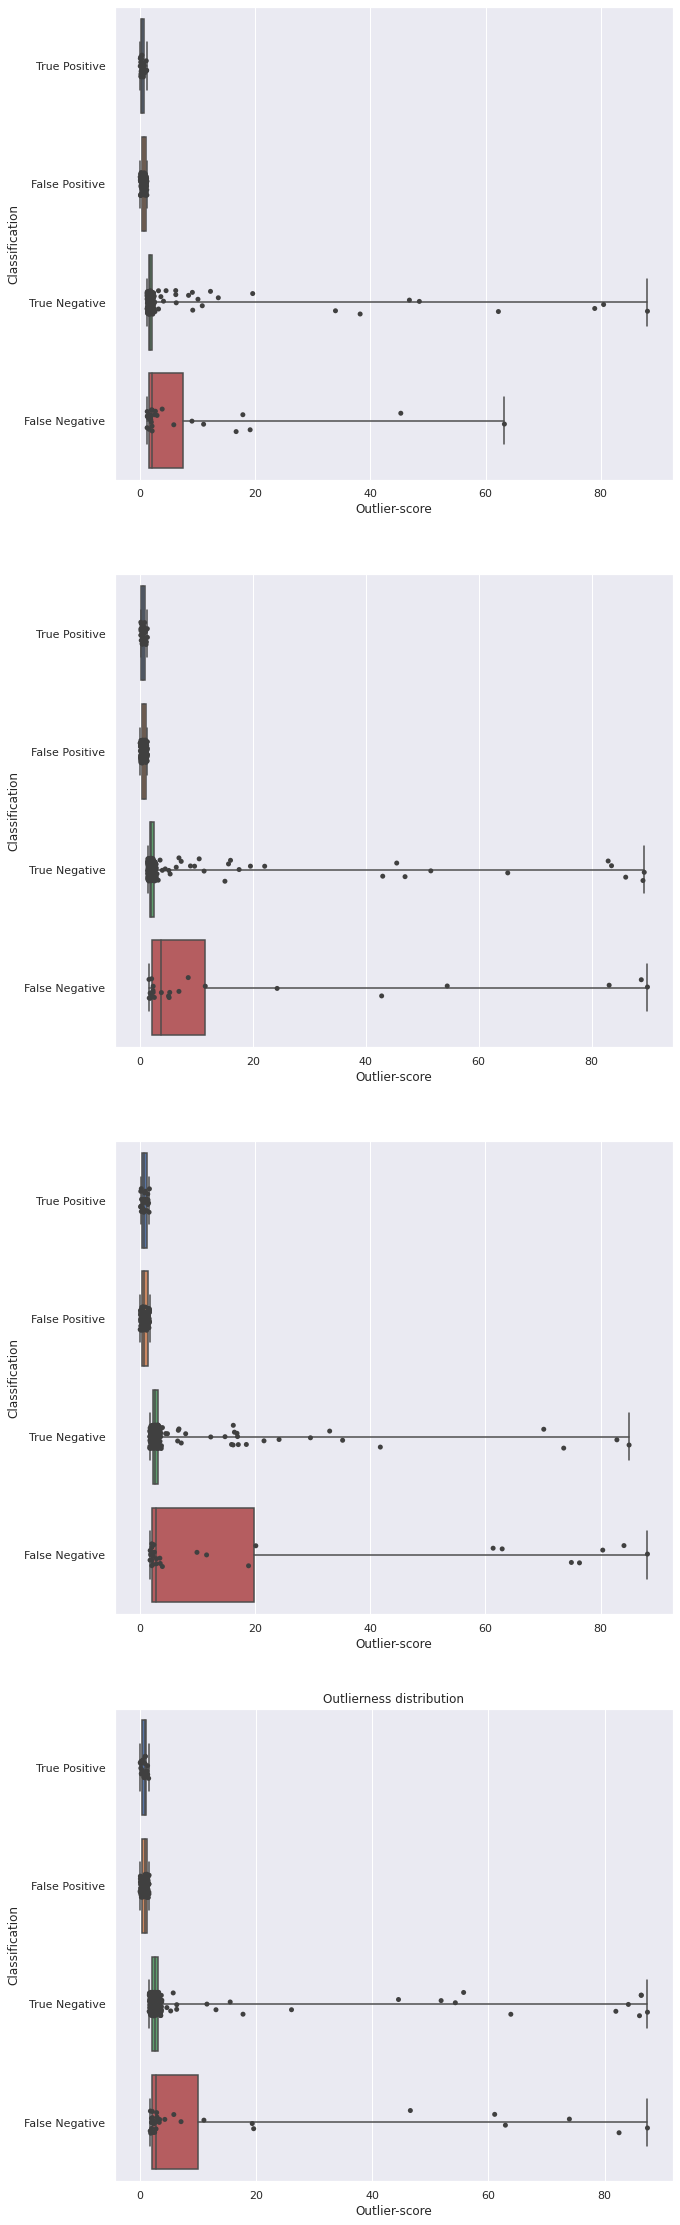

In [212]:
outlierness_plot_total(Y_collection, prediction_dict, outlierness_dict, 1, -1)

**Confusion matrices**

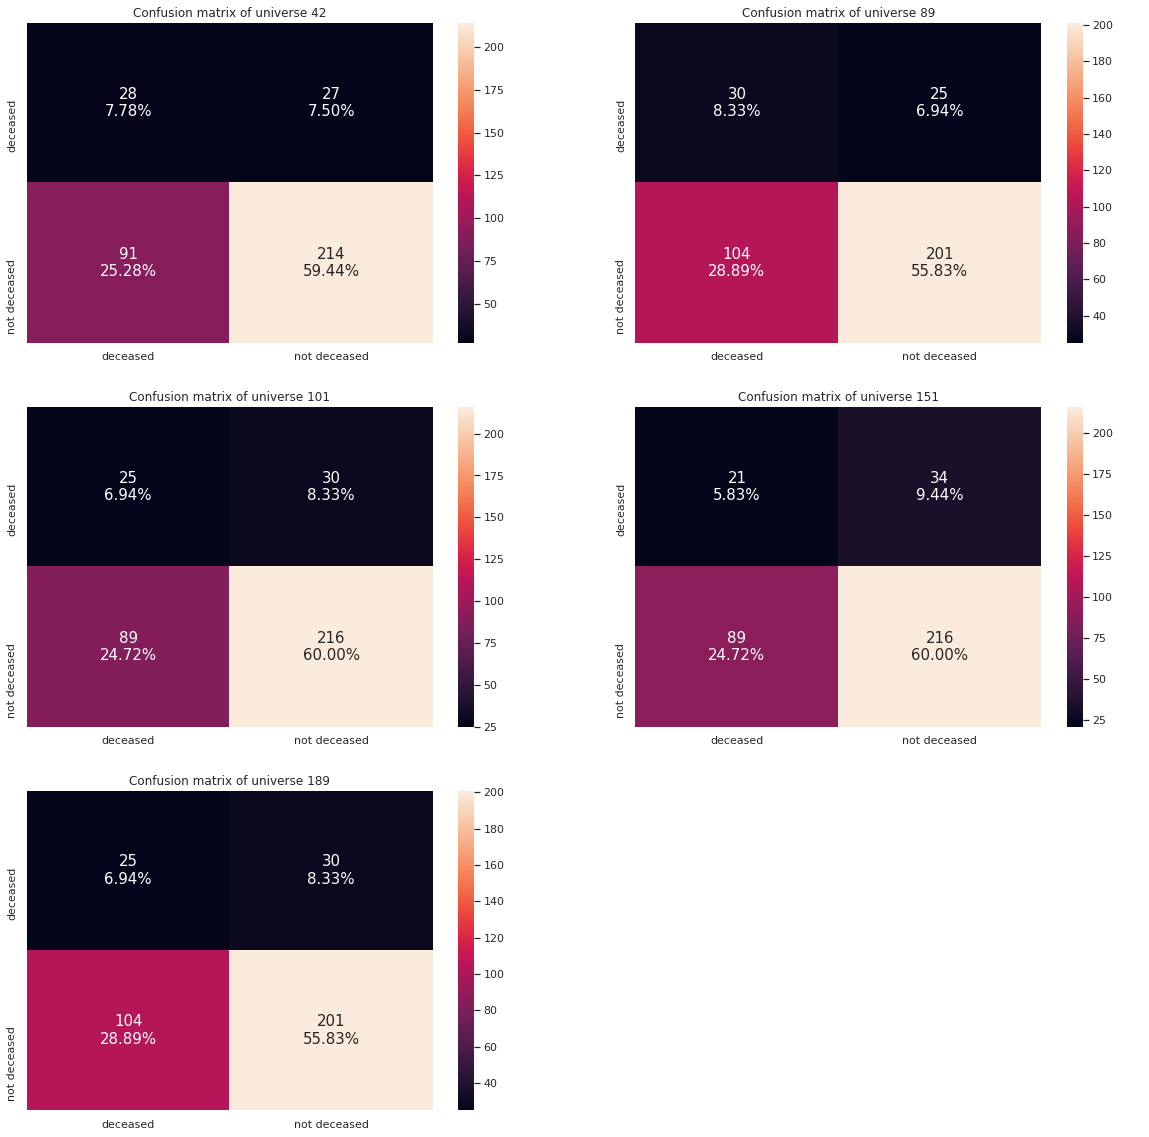

In [213]:
confusion_matrix_plot_total(y_true=Y_collection,y_pred=prediction_dict,labels=[1,-1],normal='deceased',anomaly='not deceased',)

**ROC**

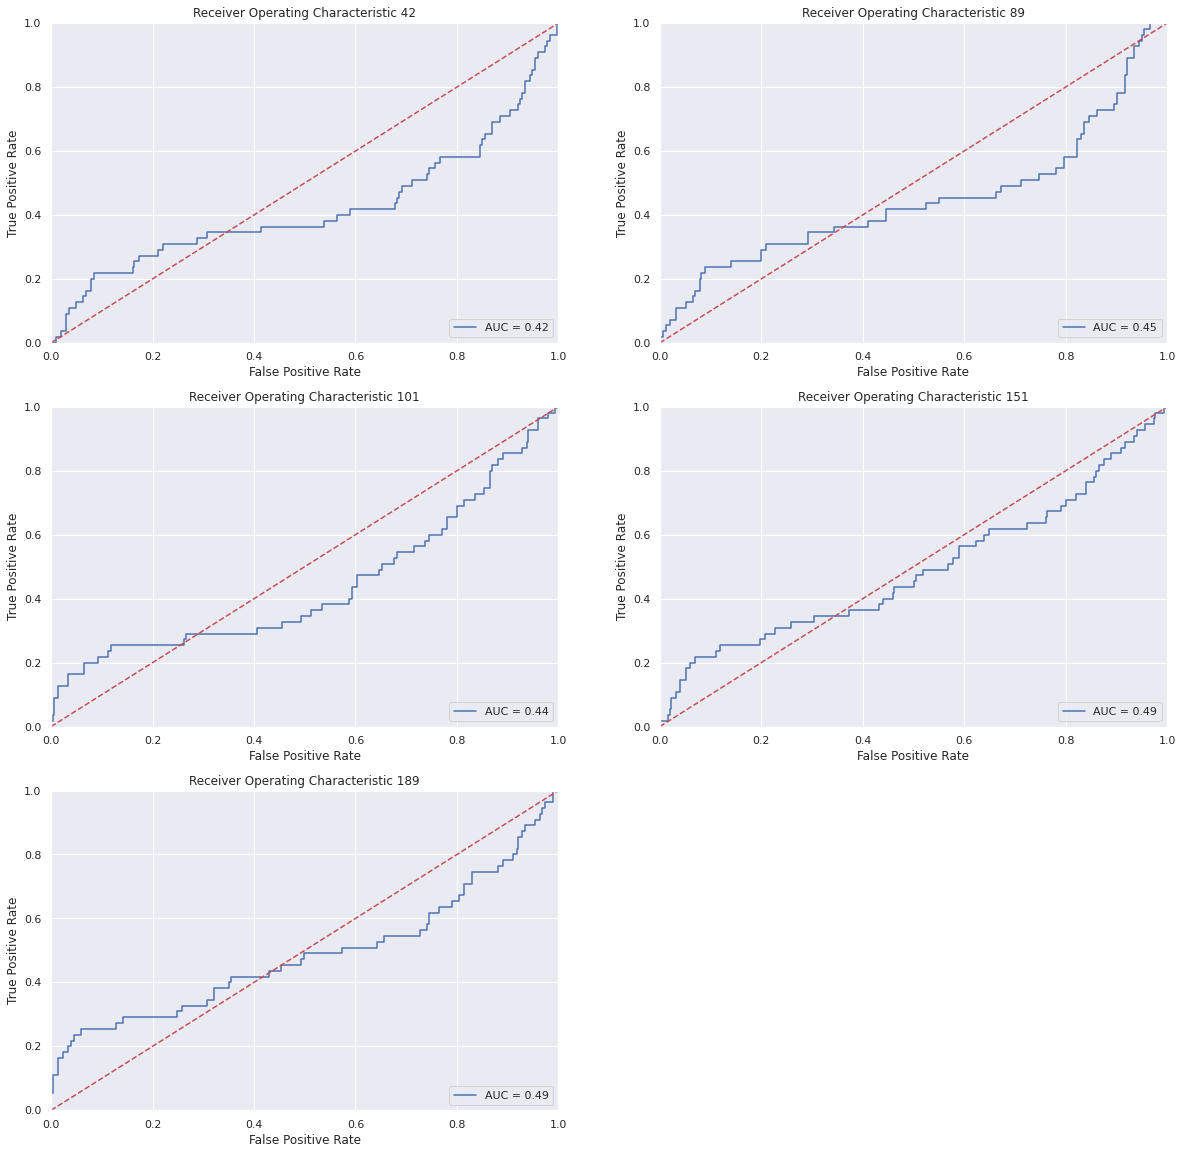

In [214]:
ROC_plot_total(Y_collection, outlierness_dict, 1)

**Evaluation**

In [215]:
ev = metric_evaluation(Y_collection, prediction_dict, outlierness_dict, 1)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Prediction      |   Pos Neg [42]  |   Pos Neg [89]  |  Pos Neg [101]  |  Pos Neg [151]  |  Pos Neg [189]  |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Positive        |       28 27     |       30 25     |       25 30     |       21 34     |       25 30     |
| Negative        |      91 214     |     104 201     |      89 216     |      89 216     |     104 201     |
| --------------- | --------------- | --------------- | --------------- | --------------- | --------------- |
| AUC             |      0.420      |      0.447      |      0.443      |      0.490*     |      0.488      |
| Accuracy        |      0.672*     |      0.642      |      0.669      |      0.658      |      0.628      |
| Precision       |      0.235*     |      0.224      |      0.219      |      0.191      |      0.194      |
| Sensitiv

Normal class: ***not deceased***

In [90]:
ocsvm = OneClassSVM()
normal = -1

low_gamma = 1e-9
top_gamma = 1e-7

low_nu = 1
top_nu = 1e-5

ocsvm_params = {
        'gamma': np.linspace(low_gamma, top_gamma, 5+1)[1:],
        'nu': np.linspace(low_nu, top_nu, 5+1)[1:]
    }

# Obtain model with best hyperparameters: nested-cv
estimator_ocsvm = nested_cv(X_collection[42][0], Y_collection[42][0], 5,5, model=ocsvm, score=f1_score, parameters=ocsvm_params, one_class=1, normal_target = -1)

# Fit train data
index_normal = Y_collection[42][0].loc[Y_collection[42][0]['ED0DISWHY']==normal].index
estimator_ocsvm.fit(X_collection[42][0].iloc[index_normal])


# Predict unproccessed outlier-score
decicision_function = estimator_ocsvm.decision_function(X_collection[42][1])

# Process outlier-score or outlierness
# Outlier-score:
# Lower the score, lower the likelihood of being outlier.
# Higher the score, higher the likelihood of being outlier.

MIN = min(decicision_function)
outlier_score = decicision_function - MIN

Metrics: f1-score
Summary:
Outer fold nº1.
Parameters (best of cv): {'gamma': 2.0799999999999998e-08, 'nu': 1e-05}
Score (best of cv): 0.915±0.0053
Score (outer): 0.07634

Outer fold nº2.
Parameters (best of cv): {'gamma': 6.04e-08, 'nu': 1e-05}
Score (best of cv): 0.921±0.0016
Score (outer): 0.9146

Outer fold nº3.
Parameters (best of cv): {'gamma': 1e-07, 'nu': 1e-05}
Score (best of cv): 0.924±0.0029
Score (outer): 0.9153

Outer fold nº4.
Parameters (best of cv): {'gamma': 1e-07, 'nu': 1e-05}
Score (best of cv): 0.911±0.0018
Score (outer): 0.615

Outer fold nº5.
Parameters (best of cv): {'gamma': 1e-07, 'nu': 1e-05}
Score (best of cv): 0.921±0.0043
Score (outer): 0.8659



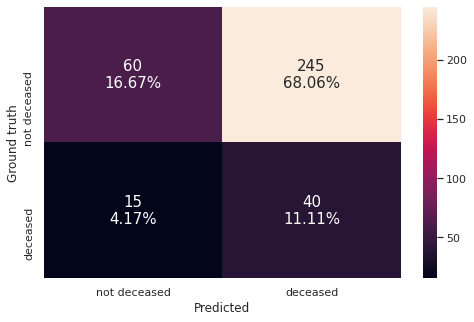

0.31578947368421056


In [94]:
pred = estimator_ocsvm.predict(X_collection[42][1])

array = confusion_matrix(y_true=Y_collection[42][1], y_pred=pred, labels=[-1,1])
normal = 'not deceased'
anomaly = 'deceased'

df_cm = pd.DataFrame({normal: array[:,0], anomaly: array[:,1]}, index=[normal, anomaly])

total = df_cm[normal].sum()+df_cm[anomaly].sum()

df_cm_p = df_cm.applymap(str)
df_cm_p[normal][normal] = df_cm_p[normal][normal]+'\n'+"{:.2f}".format(df_cm[normal][normal]/total*100)+'%'
df_cm_p[normal][anomaly] = df_cm_p[normal][anomaly]+'\n'+"{:.2f}".format(df_cm[normal][anomaly]/total*100)+'%'
df_cm_p[anomaly][normal] = df_cm_p[anomaly][normal]+'\n'+"{:.2f}".format(df_cm[anomaly][normal]/total*100)+'%'
df_cm_p[anomaly][anomaly] = df_cm_p[anomaly][anomaly]+'\n'+"{:.2f}".format(df_cm[anomaly][anomaly]/total*100)+'%'

plt.figure(figsize=(8,5))

sns.heatmap(df_cm, annot=df_cm_p, fmt='', annot_kws={"size": 15}) # font size
plt.ylabel("Ground truth")
plt.xlabel("Predicted") 

plt.show()
print(f1_score(Y_collection[42][1]['ED0DISWHY'],pred,pos_label = -1))

**Outlierness representation**

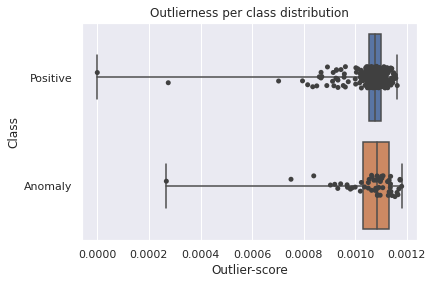

In [95]:
# Visualization of the outlierness distribution

index = Y_collection[42][1].index
anomaly_index = index[Y_collection[42][1]['ED0DISWHY']==1]
positive_index = index[Y_collection[42][1]['ED0DISWHY']==-1]
d = {'Outlier-score':outlier_score[positive_index], 'Class':len(outlier_score[positive_index])*['Positive']}
df_positive = pd.DataFrame(data=d)
d = {'Outlier-score':outlier_score[anomaly_index], 'Class':len(outlier_score[anomaly_index])*['Anomaly']}
df_anomaly = pd.DataFrame(data=d)

df_scores = pd.concat([df_positive, df_anomaly])

plt.title('Outlierness per class distribution')
sns.boxplot(y='Class', x='Outlier-score', data=df_scores, whis=np.inf)
sns.stripplot(y='Class', x='Outlier-score', data=df_scores, color=".25")

plt.show()

**ROC**

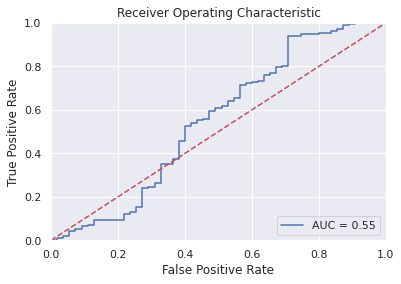

In [93]:
norm_outlier_score = 1-normalize(outlier_score)
fpr, tpr, thresholds = roc_curve(Y_collection[42][1], norm_outlier_score, pos_label=-1)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

<a id='model_oc:ocsvm'></a>
## MODELS

**Isolation Forest**

In [151]:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(contamination=0.8, random_state=42)

outlierness_dict = {}
prediction_dict = {}

for universe in ms:
    # Fit test data
    index_normal = Y_collection[universe][0].loc[Y_collection[universe][0]['ED0DISWHY']==1].index
    iforest.fit(X_collection[universe][0].iloc[index_normal])
    
    # Predict unproccessed outlier-score
    decicision_function = iforest.decision_function(X_collection[universe][1])

    # Process outlier-score or outlierness:
    # Lower the score, lower the likelihood of being outlier.
    # Higher the score, higher the likelihood of being outlier.
    MIN = min(-decicision_function)
    
    ## IsolationForest decision_function is between -0.5 and 0.5, where smaller values mean more anomalous. 
    outlier_score = -decicision_function - MIN
    
    prediction = pd.Series(iforest.predict(X_collection[universe][1]))
    
    outlierness_dict[universe] = pd.Series(outlier_score)
    prediction_dict[universe] = pd.Series(prediction)


In [152]:
ev = metric_evaluation(Y_collection, prediction_dict, outlierness_dict, 1)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Prediction      |   Pos Neg [42]  |   Pos Neg [89]  |  Pos Neg [101]  |  Pos Neg [151]  |  Pos Neg [189]  |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Positive        |       8 47      |       16 39     |       12 43     |       13 42     |       16 39     |
| Negative        |      40 265     |      58 247     |      50 255     |      64 241     |      58 247     |
| --------------- | --------------- | --------------- | --------------- | --------------- | --------------- |
| AUC             |      0.445      |      0.476      |      0.496      |      0.518*     |      0.442      |
| Accuracy        |      0.758*     |      0.731      |      0.742      |      0.706      |      0.731      |
| Precision       |      0.167      |      0.216*     |      0.194      |      0.169      |      0.216      |
| Sensitiv

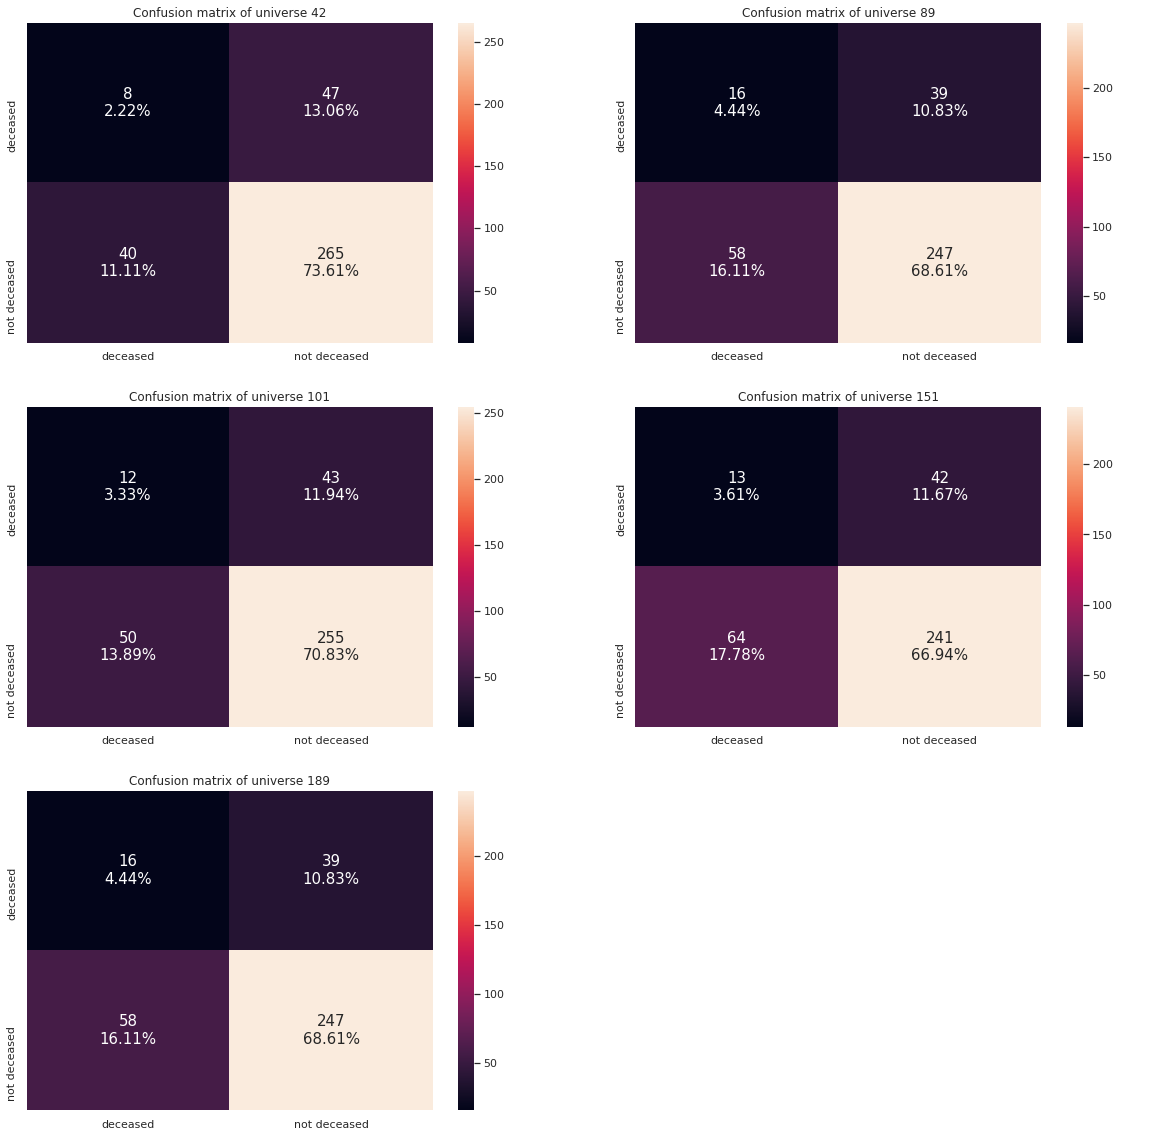

In [153]:
confusion_matrix_plot_total(y_true=Y_collection,y_pred=prediction_dict,labels=[1,-1],normal='deceased',anomaly='not deceased',)

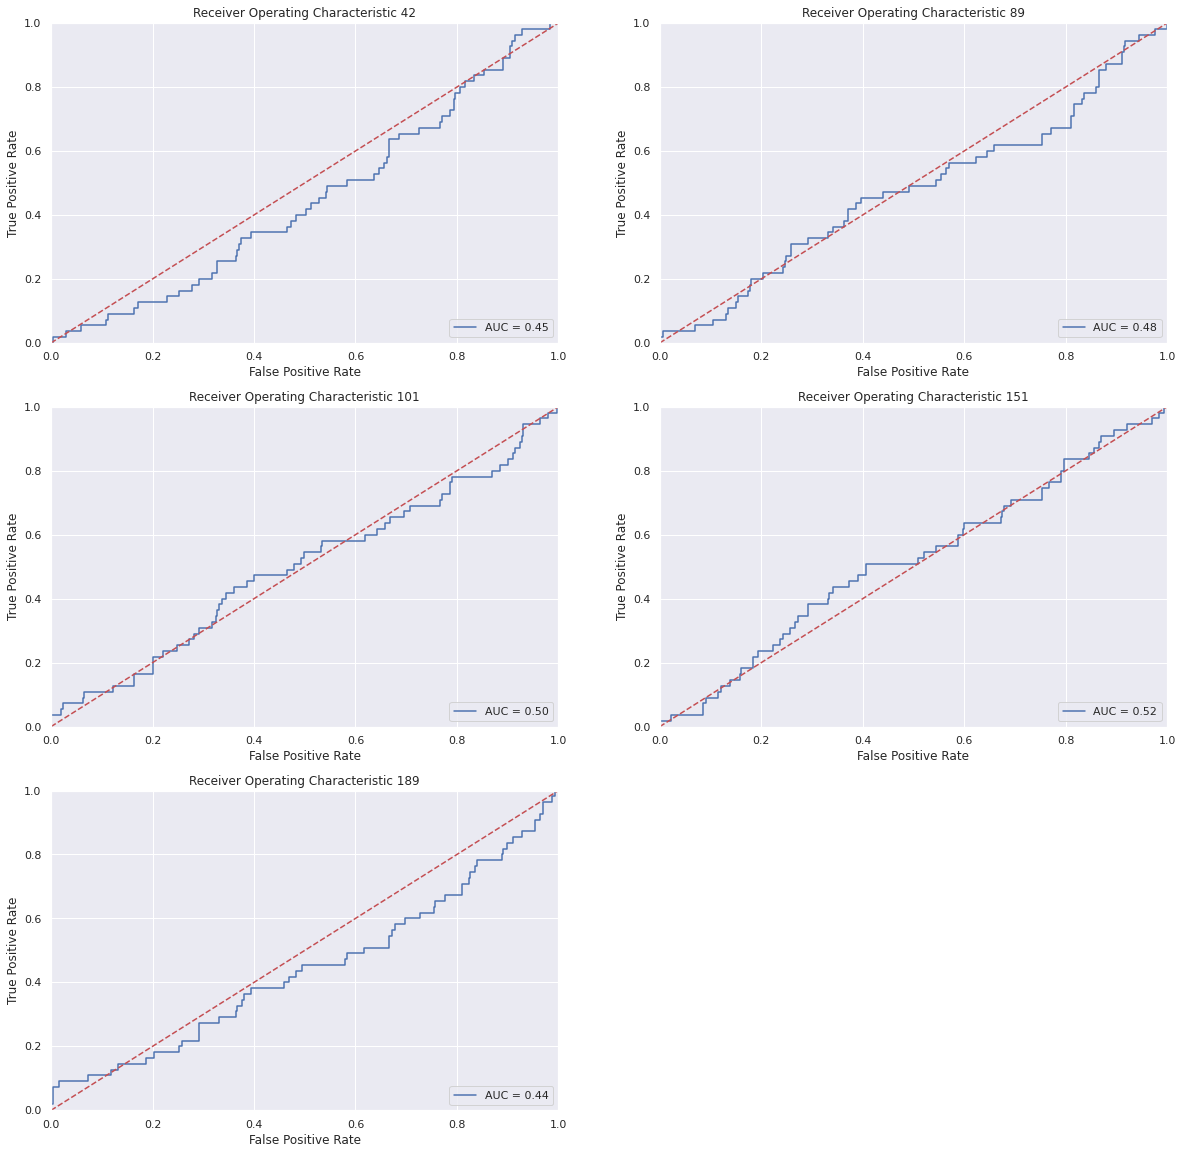

In [154]:
ROC_plot_total(Y_collection, outlierness_dict, 1)

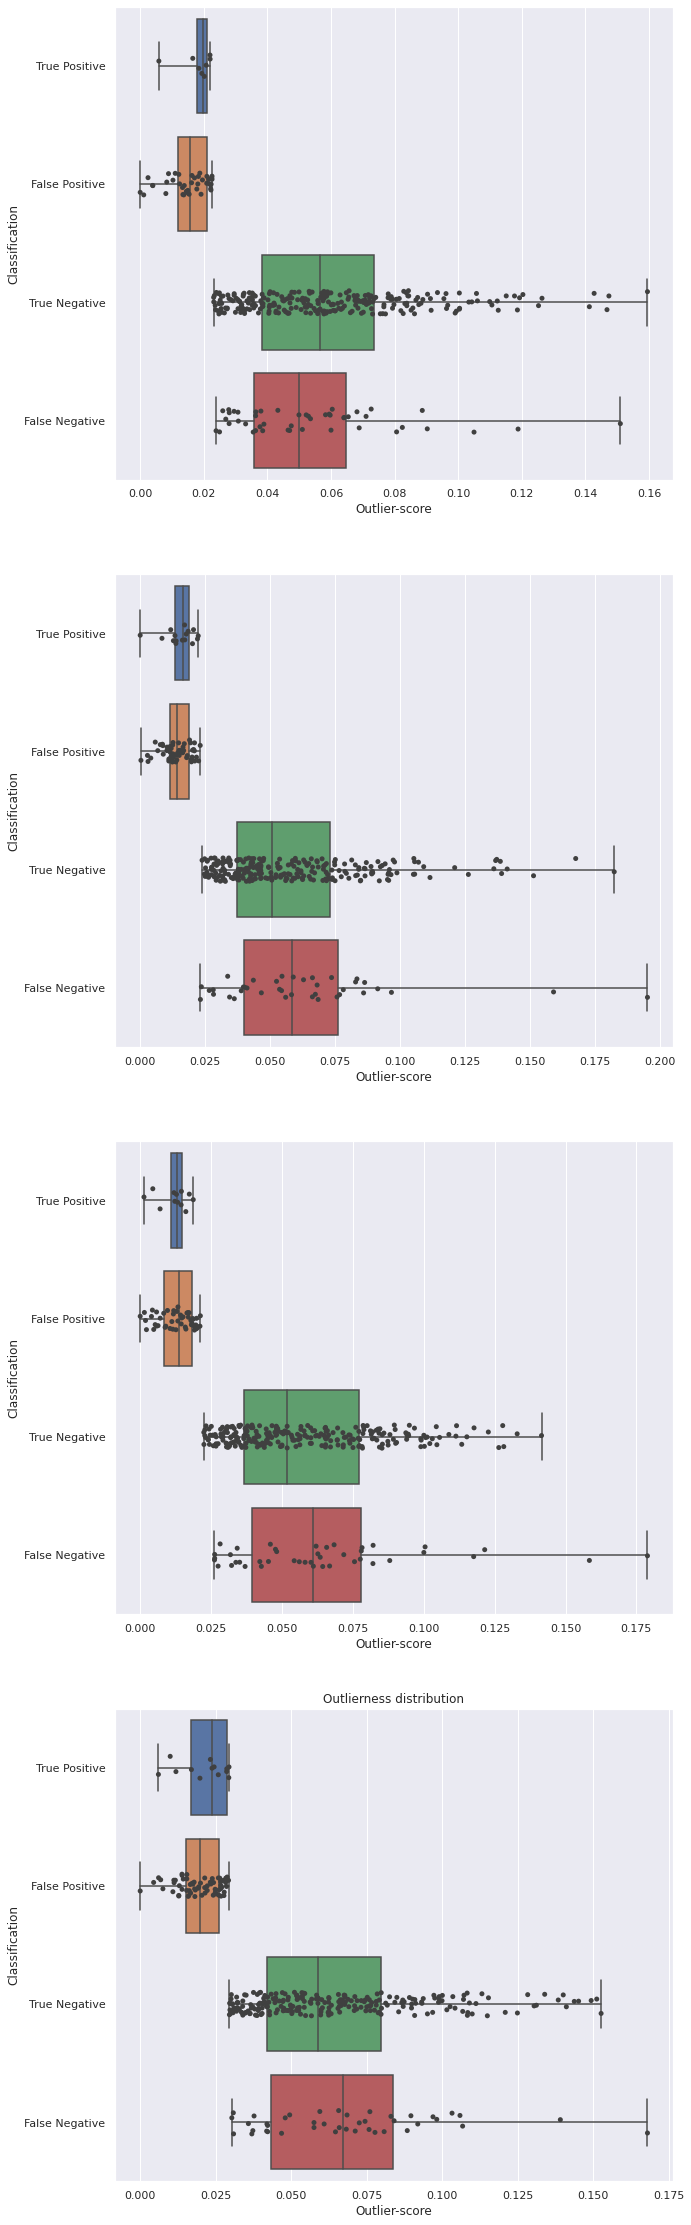

In [155]:
outlierness_plot_total(Y_collection, prediction_dict, outlierness_dict, 1, -1)

**LOF**

In [26]:
from sklearn.neighbors import LocalOutlierFactor
LOF = LocalOutlierFactor(novelty=True)

outlierness_dict = {}
prediction_dict = {}

for universe in ms:
    # Fit test data
    index_normal = Y_collection[universe][0].loc[Y_collection[universe][0]['ED0DISWHY']==1].index
    LOF.fit(X_collection[universe][0].iloc[index_normal])

    # Predict unproccessed outlier-score
    decicision_function = LOF.decision_function(X_collection[universe][1])

    # Process outlier-score or outlierness:
    # Lower the score, lower the likelihood of being outlier.
    # Higher the score, higher the likelihood of being outlier.
    MIN = min(decicision_function)
    outlier_score = decicision_function - MIN
    
    prediction = pd.Series(LOF.predict(X_collection[42][1]))
    
    outlierness_dict[universe] = pd.Series(outlier_score)
    prediction_dict[universe] = pd.Series(prediction)


In [28]:
ev = metric_evaluation(Y_collection, prediction_dict, outlierness_dict, 1)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Prediction      |   Pos Neg [42]  |   Pos Neg [89]  |  Pos Neg [101]  |  Pos Neg [151]  |  Pos Neg [189]  |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Positive        |       48 7      |       51 4      |       52 3      |       54 1      |       51 4      |
| Negative        |      289 16     |      287 18     |      286 19     |      284 21     |      283 22     |
| --------------- | --------------- | --------------- | --------------- | --------------- | --------------- |
| AUC             |      0.619*     |      0.575      |      0.572      |      0.565      |      0.605      |
| Accuracy        |      0.178      |      0.192      |      0.197      |      0.208*     |      0.203      |
| Precision       |      0.142      |      0.151      |      0.154      |      0.160*     |      0.153      |
| Sensitiv

<a id='model:cat_binary'></a>
## Binary (supervised) classification models
